## Lab 2

### Lab2 (a) Model preperation

In [1]:
from resnet20 import ResNetCIFAR
from train_util import train, finetune, test
import torch
import numpy as np

import time

import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.optim as optim

from FP_layers import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
net = ResNetCIFAR(num_layers=20, Nbits=None)
net = net.to(device)

In [3]:
# Load the best weight paramters
net.load_state_dict(torch.load("pretrained_model.pt"))
test(net)

Files already downloaded and verified
Test Loss=0.3231, Test accuracy=0.9151


### Lab2 (b) Prune by percentage

In [4]:
def prune_by_percentage(layer, q=70.0):
    """
    Pruning the weight paramters by threshold.
    :param q: pruning percentile. 'q' percent of the least 
    significant weight parameters will be pruned.
    """
    # Convert the weight of "layer" to numpy array
    weight = layer.weight.data.cpu().numpy()
    
    # Compute the q-th percentile of the abs of the converted array
    threshold = np.percentile(np.abs(weight), q)
    
    # Generate a binary mask same shape as weight to decide which element to prune
    mask = np.abs(weight) > threshold      # return True or False
    
    # Convert mask to torch tensor and put on GPU
    mask = torch.from_numpy(mask).to(device)

    # Multiply the weight by mask to perform pruning
    layer.weight.data.mul_(mask)
    
    pass
    

In [5]:
net.load_state_dict(torch.load("pretrained_model.pt"))

for name,layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        # change q value
        prune_by_percentage(layer, q=70.0)
        
        # Optional: Check the sparsity you achieve in each layer
        # Convert the weight of "layer" to numpy array
        np_weight = layer.weight.data.cpu().numpy()
        # Count number of zeros
        zeros = np.sum(np_weight==0)
        # Count number of parameters
        total = np_weight.size
        # Print sparsity
        print('Sparsity of '+name+': '+str(zeros/total))
        
test(net)

Sparsity of head_conv.0.conv: 0.6990740740740741
Sparsity of body_op.0.conv1.0.conv: 0.7000868055555556
Sparsity of body_op.0.conv2.0.conv: 0.7000868055555556
Sparsity of body_op.1.conv1.0.conv: 0.7000868055555556
Sparsity of body_op.1.conv2.0.conv: 0.7000868055555556
Sparsity of body_op.2.conv1.0.conv: 0.7000868055555556
Sparsity of body_op.2.conv2.0.conv: 0.7000868055555556
Sparsity of body_op.3.conv1.0.conv: 0.6998697916666666
Sparsity of body_op.3.conv2.0.conv: 0.6999782986111112
Sparsity of body_op.4.conv1.0.conv: 0.6999782986111112
Sparsity of body_op.4.conv2.0.conv: 0.6999782986111112
Sparsity of body_op.5.conv1.0.conv: 0.6999782986111112
Sparsity of body_op.5.conv2.0.conv: 0.6999782986111112
Sparsity of body_op.6.conv1.0.conv: 0.6999782986111112
Sparsity of body_op.6.conv2.0.conv: 0.7000054253472222
Sparsity of body_op.7.conv1.0.conv: 0.7000054253472222
Sparsity of body_op.7.conv2.0.conv: 0.7000054253472222
Sparsity of body_op.8.conv1.0.conv: 0.7000054253472222
Sparsity of body

In [6]:
# try prunning q=0.3,0.5,0.7
for q in [30, 50, 70]:
    net.load_state_dict(torch.load("pretrained_model.pt"))
    print(f"Current q: {q}")

    for name,layer in net.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
            # change q value
            prune_by_percentage(layer, q=q)
            
            # Optional: Check the sparsity you achieve in each layer
            # Convert the weight of "layer" to numpy array
            np_weight = layer.weight.data.cpu().numpy()
            # Count number of zeros
            zeros = np.sum(np_weight==0)
            # Count number of parameters
            total = np_weight.size
            # Print sparsity
            print('Sparsity of '+name+': '+str(zeros/total))
            
    test(net)
    print('========================')

Current q: 30
Sparsity of head_conv.0.conv: 0.30092592592592593
Sparsity of body_op.0.conv1.0.conv: 0.2999131944444444
Sparsity of body_op.0.conv2.0.conv: 0.2999131944444444
Sparsity of body_op.1.conv1.0.conv: 0.2999131944444444
Sparsity of body_op.1.conv2.0.conv: 0.2999131944444444
Sparsity of body_op.2.conv1.0.conv: 0.2999131944444444
Sparsity of body_op.2.conv2.0.conv: 0.2999131944444444
Sparsity of body_op.3.conv1.0.conv: 0.3001302083333333
Sparsity of body_op.3.conv2.0.conv: 0.3000217013888889
Sparsity of body_op.4.conv1.0.conv: 0.3000217013888889
Sparsity of body_op.4.conv2.0.conv: 0.3000217013888889
Sparsity of body_op.5.conv1.0.conv: 0.3000217013888889
Sparsity of body_op.5.conv2.0.conv: 0.3000217013888889
Sparsity of body_op.6.conv1.0.conv: 0.3000217013888889
Sparsity of body_op.6.conv2.0.conv: 0.2999945746527778
Sparsity of body_op.7.conv1.0.conv: 0.2999945746527778
Sparsity of body_op.7.conv2.0.conv: 0.2999945746527778
Sparsity of body_op.8.conv1.0.conv: 0.2999945746527778
S

### Lab2 (c) Finetune pruned model

In [7]:
def finetune_after_prune(net, trainloader, criterion, optimizer, prune=True):
    """
    Finetune the pruned model for a single epoch
    Make sure pruned weights are kept as zero
    """
    # Build a dictionary for the nonzero weights
    weight_mask = {}
    for name,layer in net.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
            # Your code here: generate a mask in GPU torch tensor to have 1 for nonzero element and 0 for zero element 
            weight_mask[name] = (layer.weight.data != 0).float().to(device)
    
    global_steps = 0
    train_loss = 0
    correct = 0
    total = 0
    start = time.time()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        if prune:
            for name,layer in net.named_modules():
                if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
                    # Your code here: Use weight_mask to make sure zero elements remains zero
                    layer.weight.data.mul_(weight_mask[name])
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        global_steps += 1

        if global_steps % 50 == 0:
            end = time.time()
            batch_size = 256
            num_examples_per_second = 50 * batch_size / (end - start)
            print("[Step=%d]\tLoss=%.4f\tacc=%.4f\t%.1f examples/second"
                 % (global_steps, train_loss / (batch_idx + 1), (correct / total), num_examples_per_second))
            start = time.time()
    
    

In [8]:
# Get pruned model
net.load_state_dict(torch.load("pretrained_model.pt"))
for name,layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        prune_by_percentage(layer, q=70.0)

# Training setup, do not change
batch_size=256
lr=0.002
reg=1e-4

print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.875, weight_decay=reg, nesterov=False)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Model finetuning
for epoch in range(20):
    print('\nEpoch: %d' % epoch)
    net.train()
    finetune_after_prune(net, trainloader, criterion, optimizer)
    #Start the testing code.
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test acc=%.4f" % (test_loss / (num_val_steps), val_acc))

    if val_acc > best_acc:
        best_acc = val_acc
        print("Saving...")
        torch.save(net.state_dict(), "net_after_finetune.pt")


Epoch: 0
[Step=50]	Loss=0.4065	acc=0.8607	3382.3 examples/second
[Step=100]	Loss=0.3671	acc=0.8732	7989.3 examples/second
[Step=150]	Loss=0.3392	acc=0.8821	8220.1 examples/second
Test Loss=0.4290, Test acc=0.8663
Saving...

Epoch: 1
[Step=50]	Loss=0.2516	acc=0.9130	6868.3 examples/second
[Step=100]	Loss=0.2454	acc=0.9143	8057.2 examples/second
[Step=150]	Loss=0.2402	acc=0.9160	7841.6 examples/second
Test Loss=0.3939, Test acc=0.8751
Saving...

Epoch: 2
[Step=50]	Loss=0.2096	acc=0.9280	6865.6 examples/second
[Step=100]	Loss=0.2096	acc=0.9279	8172.0 examples/second
[Step=150]	Loss=0.2085	acc=0.9281	7936.5 examples/second
Test Loss=0.3777, Test acc=0.8794
Saving...

Epoch: 3
[Step=50]	Loss=0.2033	acc=0.9293	6514.7 examples/second
[Step=100]	Loss=0.2022	acc=0.9285	7991.9 examples/second
[Step=150]	Loss=0.1998	acc=0.9298	7826.6 examples/second
Test Loss=0.3677, Test acc=0.8820
Saving...

Epoch: 4
[Step=50]	Loss=0.1877	acc=0.9338	6819.5 examples/second
[Step=100]	Loss=0.1860	acc=0.9345	8097

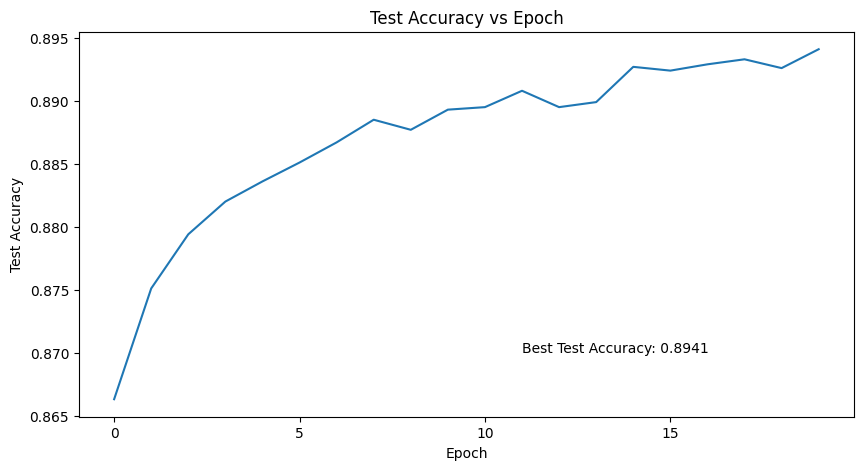

In [20]:
test_acc = [0.8663, 0.8751, 0.8794, 0.8820, 0.8836, 0.8851, 0.8867, 0.8885, 0.8877,  0.8893, 0.8895, 0.8908, 0.8895, 0.8899, 0.8927, 0.8924, 0.8929, 0.8933, 0.8926, 0.8941]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(test_acc)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.xticks(np.arange(0, 20, 5))
plt.title('Test Accuracy vs Epoch')
plt.text(11, 0.87, f'Best Test Accuracy: {max(test_acc):.4f}')
plt.show()


In [10]:
# Check sparsity of the finetuned model, make sure it's not changed
net.load_state_dict(torch.load("net_after_finetune.pt"))

for name,layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        # Your code here:
        # Convert the weight of "layer" to numpy array
        np_weight = layer.weight.data.cpu().numpy() 
        # Count number of zeros
        zeros = np.sum(np_weight==0)
        # Count number of parameters
        total = np_weight.size
        # Print sparsity
        print('Sparsity of '+name+': '+str(zeros/total))

test(net)

Sparsity of head_conv.0.conv: 0.6990740740740741
Sparsity of body_op.0.conv1.0.conv: 0.7000868055555556
Sparsity of body_op.0.conv2.0.conv: 0.7000868055555556
Sparsity of body_op.1.conv1.0.conv: 0.7000868055555556
Sparsity of body_op.1.conv2.0.conv: 0.7000868055555556
Sparsity of body_op.2.conv1.0.conv: 0.7000868055555556
Sparsity of body_op.2.conv2.0.conv: 0.7000868055555556
Sparsity of body_op.3.conv1.0.conv: 0.6998697916666666
Sparsity of body_op.3.conv2.0.conv: 0.6999782986111112
Sparsity of body_op.4.conv1.0.conv: 0.6999782986111112
Sparsity of body_op.4.conv2.0.conv: 0.6999782986111112
Sparsity of body_op.5.conv1.0.conv: 0.6999782986111112
Sparsity of body_op.5.conv2.0.conv: 0.6999782986111112
Sparsity of body_op.6.conv1.0.conv: 0.6999782986111112
Sparsity of body_op.6.conv2.0.conv: 0.7000054253472222
Sparsity of body_op.7.conv1.0.conv: 0.7000054253472222
Sparsity of body_op.7.conv2.0.conv: 0.7000054253472222
Sparsity of body_op.8.conv1.0.conv: 0.7000054253472222
Sparsity of body

### Lab2 (d) Iterative pruning

In [24]:
net.load_state_dict(torch.load("pretrained_model.pt"))
best_acc = 0.
l_val_acc = []
for epoch in range(20):
    print('\nEpoch: %d' % epoch)
    
    net.train()
    if epoch<10:
        for name,layer in net.named_modules():
            if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
                # Increase model sparsity
                q = 7 * (epoch+1)
                prune_by_percentage(layer, q=q)
    if epoch<9:
        finetune_after_prune(net, trainloader, criterion, optimizer,prune=False)
    else:
        finetune_after_prune(net, trainloader, criterion, optimizer)
    
    #Start the testing code.
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test acc=%.4f" % (test_loss / (num_val_steps), val_acc))
    l_val_acc.append(val_acc)
    
    if epoch>=10:
        if val_acc > best_acc:
            best_acc = val_acc
            print("Saving...")
            torch.save(net.state_dict(), "net_after_iterative_prune.pt")


Epoch: 0
[Step=50]	Loss=0.0463	acc=0.9846	6756.1 examples/second
[Step=100]	Loss=0.0491	acc=0.9838	8069.4 examples/second
[Step=150]	Loss=0.0485	acc=0.9846	7195.1 examples/second
Test Loss=0.3263, Test acc=0.9152

Epoch: 1
[Step=50]	Loss=0.0484	acc=0.9843	6859.3 examples/second
[Step=100]	Loss=0.0476	acc=0.9846	7950.5 examples/second
[Step=150]	Loss=0.0477	acc=0.9846	7195.2 examples/second
Test Loss=0.3266, Test acc=0.9150

Epoch: 2
[Step=50]	Loss=0.0471	acc=0.9854	6583.9 examples/second
[Step=100]	Loss=0.0498	acc=0.9840	7820.0 examples/second
[Step=150]	Loss=0.0513	acc=0.9835	7364.9 examples/second
Test Loss=0.3273, Test acc=0.9140

Epoch: 3
[Step=50]	Loss=0.0517	acc=0.9840	6243.6 examples/second
[Step=100]	Loss=0.0528	acc=0.9832	7845.9 examples/second
[Step=150]	Loss=0.0532	acc=0.9832	7498.1 examples/second
Test Loss=0.3276, Test acc=0.9127

Epoch: 4
[Step=50]	Loss=0.0617	acc=0.9802	6421.9 examples/second
[Step=100]	Loss=0.0622	acc=0.9791	7639.5 examples/second
[Step=150]	Loss=0.060

In [25]:
# Check sparsity of the final model, make sure it's 70%
net.load_state_dict(torch.load("net_after_iterative_prune.pt"))

for name,layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        # Your code here: can copy from previous question
        # Convert the weight of "layer" to numpy array
        np_weight = layer.weight.data.cpu().numpy() 
        # Count number of zeros
        zeros = np.sum(np_weight==0)
        # Count number of parameters
        total = np_weight.size
        # Print sparsity
        print('Sparsity of '+name+': '+str(zeros/total))        
        
test(net)

Sparsity of head_conv.0.conv: 0.6990740740740741
Sparsity of body_op.0.conv1.0.conv: 0.7000868055555556
Sparsity of body_op.0.conv2.0.conv: 0.7000868055555556
Sparsity of body_op.1.conv1.0.conv: 0.7000868055555556
Sparsity of body_op.1.conv2.0.conv: 0.7000868055555556
Sparsity of body_op.2.conv1.0.conv: 0.7000868055555556
Sparsity of body_op.2.conv2.0.conv: 0.7000868055555556
Sparsity of body_op.3.conv1.0.conv: 0.6998697916666666
Sparsity of body_op.3.conv2.0.conv: 0.6999782986111112
Sparsity of body_op.4.conv1.0.conv: 0.6999782986111112
Sparsity of body_op.4.conv2.0.conv: 0.6999782986111112
Sparsity of body_op.5.conv1.0.conv: 0.6999782986111112
Sparsity of body_op.5.conv2.0.conv: 0.6999782986111112
Sparsity of body_op.6.conv1.0.conv: 0.6999782986111112
Sparsity of body_op.6.conv2.0.conv: 0.7000054253472222
Sparsity of body_op.7.conv1.0.conv: 0.7000054253472222
Sparsity of body_op.7.conv2.0.conv: 0.7000054253472222
Sparsity of body_op.8.conv1.0.conv: 0.7000054253472222
Sparsity of body

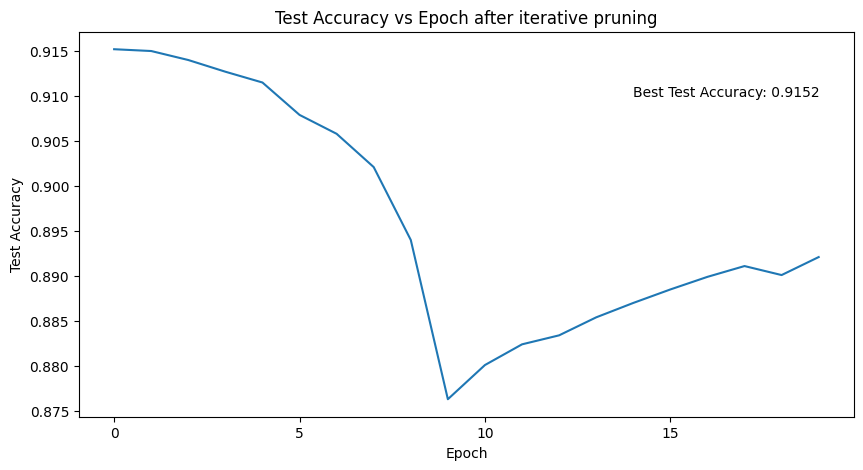

In [28]:
# plot the test accuracy
plt.figure(figsize=(10, 5))
plt.plot(l_val_acc)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.xticks(np.arange(0, 20, 5))
plt.title('Test Accuracy vs Epoch after iterative pruning')
plt.text(14, 0.91, f'Best Test Accuracy: {max(l_val_acc):.4f}')
plt.show()

### Lab2 (e) Global iterative pruning

In [29]:
def global_prune_by_percentage(net, q=70.0):
    """
    Pruning the weight paramters by threshold.
    :param q: pruning percentile. 'q' percent of the least 
    significant weight parameters will be pruned.
    """
    # A list to gather all the weights
    flattened_weights = []
    # Find global pruning threshold
    for name,layer in net.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
            # Convert weight to numpy
            np_weight = layer.weight.data.cpu().numpy()
            # Flatten the weight and append to flattened_weights
            flattened_weights.append(np_weight.flatten())
    
    # Concate all weights into a np array
    flattened_weights = np.concatenate(flattened_weights)
    # Find global pruning threshold
    thres = np.percentile(np.abs(flattened_weights), q)
    
    # Apply pruning threshold to all layers
    for name,layer in net.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
            # Convert weight to numpy
            np_weight = layer.weight.data.cpu().numpy()
            
            # Generate a binary mask same shape as weight to decide which element to prune
            mask = np.abs(np_weight) > thres
            
            # Convert mask to torch tensor and put on GPU
            mask = torch.from_numpy(mask).to(device)
            
            # Multiply the weight by mask to perform pruning
            layer.weight.data.mul_(mask)            

In [32]:
net.load_state_dict(torch.load("pretrained_model.pt"))
best_acc = 0.
for epoch in range(20):
    print('\nEpoch: %d' % epoch)
    q=(epoch+1)*7
    
    net.train()
    # Increase model sparsity
    if epoch<10:
        global_prune_by_percentage(net, q=q)
    if epoch<9:
        finetune_after_prune(net, trainloader, criterion, optimizer,prune=False)
    else:
        finetune_after_prune(net, trainloader, criterion, optimizer)
    
    #Start the testing code.
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test acc=%.4f" % (test_loss / (num_val_steps), val_acc))
    
    if epoch>=10:
        if val_acc > best_acc:
            best_acc = val_acc
            print("Saving...")
            torch.save(net.state_dict(), "net_after_global_iterative_prune.pt")


Epoch: 0
[Step=50]	Loss=0.0490	acc=0.9850	6796.1 examples/second
[Step=100]	Loss=0.0492	acc=0.9854	7205.9 examples/second
[Step=150]	Loss=0.0492	acc=0.9853	7366.1 examples/second
Test Loss=0.3262, Test acc=0.9141

Epoch: 1
[Step=50]	Loss=0.0485	acc=0.9839	6674.1 examples/second
[Step=100]	Loss=0.0475	acc=0.9848	7548.9 examples/second
[Step=150]	Loss=0.0486	acc=0.9841	7798.1 examples/second
Test Loss=0.3238, Test acc=0.9159

Epoch: 2
[Step=50]	Loss=0.0477	acc=0.9844	6735.9 examples/second
[Step=100]	Loss=0.0489	acc=0.9845	8018.2 examples/second
[Step=150]	Loss=0.0492	acc=0.9845	7533.2 examples/second
Test Loss=0.3239, Test acc=0.9139

Epoch: 3
[Step=50]	Loss=0.0483	acc=0.9844	6656.8 examples/second
[Step=100]	Loss=0.0501	acc=0.9836	7977.2 examples/second
[Step=150]	Loss=0.0511	acc=0.9834	7870.8 examples/second
Test Loss=0.3270, Test acc=0.9131

Epoch: 4
[Step=50]	Loss=0.0556	acc=0.9821	6713.9 examples/second
[Step=100]	Loss=0.0557	acc=0.9820	7665.1 examples/second
[Step=150]	Loss=0.055

In [33]:
net.load_state_dict(torch.load("net_after_global_iterative_prune.pt"))

zeros_sum = 0
total_sum = 0
for name,layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        # Your code here:
        # Convert the weight of "layer" to numpy array
        np_weight = layer.weight.data.cpu().numpy() 
        # Count number of zeros
        zeros = np.sum(np_weight==0)
        # Count number of parameters
        total = np_weight.size
        zeros_sum+=zeros
        total_sum+=total
        print('Sparsity of '+name+': '+str(zeros/total))
print('Total sparsity of: '+str(zeros_sum/total_sum))
test(net)

Sparsity of head_conv.0.conv: 0.24305555555555555
Sparsity of body_op.0.conv1.0.conv: 0.5494791666666666
Sparsity of body_op.0.conv2.0.conv: 0.5282118055555556
Sparsity of body_op.1.conv1.0.conv: 0.5190972222222222
Sparsity of body_op.1.conv2.0.conv: 0.5520833333333334
Sparsity of body_op.2.conv1.0.conv: 0.5182291666666666
Sparsity of body_op.2.conv2.0.conv: 0.5638020833333334
Sparsity of body_op.3.conv1.0.conv: 0.5260416666666666
Sparsity of body_op.3.conv2.0.conv: 0.5826822916666666
Sparsity of body_op.4.conv1.0.conv: 0.6153428819444444
Sparsity of body_op.4.conv2.0.conv: 0.6766493055555556
Sparsity of body_op.5.conv1.0.conv: 0.611328125
Sparsity of body_op.5.conv2.0.conv: 0.7038845486111112
Sparsity of body_op.6.conv1.0.conv: 0.6153428819444444
Sparsity of body_op.6.conv2.0.conv: 0.6513129340277778
Sparsity of body_op.7.conv1.0.conv: 0.6624891493055556
Sparsity of body_op.7.conv2.0.conv: 0.718994140625
Sparsity of body_op.8.conv1.0.conv: 0.7477756076388888
Sparsity of body_op.8.conv

## Lab 3

### Lab 3 (b) and (c): Fixed-point quantization

In [3]:
# Define quantized model and load weight
Nbits = 4 #Change this value to finish (b) and (c)

net = ResNetCIFAR(num_layers=20, Nbits=Nbits)
net = net.to(device)
net.load_state_dict(torch.load("pretrained_model.pt"))
test(net)


Files already downloaded and verified
Test Loss=0.3861, Test accuracy=0.8972


In [4]:
# Quantized model finetuning
finetune(net, epochs=20, batch_size=256, lr=0.002, reg=1e-4)   

# Load the model with best accuracy
net.load_state_dict(torch.load("quantized_net_after_finetune.pt"))
test(net)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified

Epoch: 0
[Step=50]	Loss=0.0670	acc=0.9768	3843.1 examples/second
[Step=100]	Loss=0.0682	acc=0.9764	3904.7 examples/second
[Step=150]	Loss=0.0682	acc=0.9764	4027.0 examples/second
Test Loss=0.3363, Test acc=0.9093
Saving...

Epoch: 1
[Step=200]	Loss=0.0515	acc=0.9834	2486.3 examples/second
[Step=250]	Loss=0.0633	acc=0.9789	3963.4 examples/second
[Step=300]	Loss=0.0603	acc=0.9797	4007.5 examples/second
[Step=350]	Loss=0.0605	acc=0.9794	4012.5 examples/second
Test Loss=0.3340, Test acc=0.9111
Saving...

Epoch: 2
[Step=400]	Loss=0.0645	acc=0.9805	2453.2 examples/second
[Step=450]	Loss=0.0600	acc=0.9795	3989.8 examples/second
[Step=500]	Loss=0.0610	acc=0.9795	3956.3 examples/second
[Step=550]	Loss=0.0616	acc=0.9795	3984.6 examples/second
Test Loss=0.3324, Test acc=0.9120
Saving...

Epoch: 3
[Step=600]	Loss=0.0598	acc=0.9818	2456.0 examples/second
[Step=650]	Loss=0.0600	acc=0.9807	3785.4 example

In [3]:
for i in [2, 3, 4, 5, 6]:
    print(f"Current Nbits: {i}")
    net = ResNetCIFAR(num_layers=20, Nbits=i)
    net = net.to(device)
    net.load_state_dict(torch.load("pretrained_model.pt"))
    test(net)

    # Quantized model finetuning
    finetune(net, epochs=20, batch_size=256, lr=0.002, reg=1e-4)   

    # Load the model with best accuracy
    net.load_state_dict(torch.load("quantized_net_after_finetune.pt"))
    test(net)
    print('========================')

Current Nbits: 2
Files already downloaded and verified
Test Loss=9.5441, Test accuracy=0.0899
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified

Epoch: 0
[Step=50]	Loss=1.3515	acc=0.6227	3681.2 examples/second
[Step=100]	Loss=1.0904	acc=0.6814	3922.4 examples/second
[Step=150]	Loss=0.9601	acc=0.7108	4042.0 examples/second
Test Loss=0.7263, Test acc=0.7803
Saving...

Epoch: 1
[Step=200]	Loss=0.5697	acc=0.8066	2452.9 examples/second
[Step=250]	Loss=0.5913	acc=0.7993	3936.6 examples/second
[Step=300]	Loss=0.5576	acc=0.8101	3946.3 examples/second
[Step=350]	Loss=0.5462	acc=0.8132	3962.0 examples/second
Test Loss=0.6394, Test acc=0.8049
Saving...

Epoch: 2
[Step=400]	Loss=0.5368	acc=0.8184	2414.9 examples/second
[Step=450]	Loss=0.4848	acc=0.8324	3973.0 examples/second
[Step=500]	Loss=0.4696	acc=0.8384	3968.3 examples/second
[Step=550]	Loss=0.4653	acc=0.8407	4001.2 examples/second
Test Loss=0.5700, Test acc=0.8201
Saving...

Epoch: 3
[Step=600]	

### Lab3 (d) Quantize pruned model

In [ ]:
# # Define quantized model and load weight
# Nbits = 3 #Change this value to finish (d)

# net = ResNetCIFAR(num_layers=20, Nbits=Nbits)
# net = net.to(device)
# net.load_state_dict(torch.load("net_after_global_iterative_prune.pt"))
# test(net)


In [ ]:
# # Quantized model finetuning
# finetune(net, epochs=20, batch_size=256, lr=0.002, reg=1e-4)

# # Load the model with best accuracy
# net.load_state_dict(torch.load("quantized_net_after_finetune.pt"))
# test(net)

In [4]:
for i in [2,3,4]:
    print(f"Current Nbits: {i}")
    net = ResNetCIFAR(num_layers=20, Nbits=i)
    net = net.to(device)
    net.load_state_dict(torch.load("net_after_global_iterative_prune.pt"))
    test(net)

    # Quantized model finetuning
    finetune(net, epochs=20, batch_size=256, lr=0.002, reg=1e-4)

    # Load the model with best accuracy
    net.load_state_dict(torch.load("quantized_net_after_finetune.pt"))
    test(net)
    print('========================')

Current Nbits: 2
Files already downloaded and verified
Test Loss=6885.1971, Test accuracy=0.1000
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified

Epoch: 0
[Step=50]	Loss=2.2583	acc=0.1446	3741.5 examples/second
[Step=100]	Loss=2.2210	acc=0.1536	3906.5 examples/second
[Step=150]	Loss=2.2033	acc=0.1588	3930.5 examples/second
Test Loss=2.1227, Test acc=0.1802
Saving...

Epoch: 1
[Step=200]	Loss=2.1479	acc=0.1768	2454.7 examples/second
[Step=250]	Loss=2.1307	acc=0.1908	3941.8 examples/second
[Step=300]	Loss=2.1206	acc=0.2015	3911.8 examples/second
[Step=350]	Loss=2.1140	acc=0.2064	3864.2 examples/second
Test Loss=2.0870, Test acc=0.2248
Saving...

Epoch: 2
[Step=400]	Loss=2.0746	acc=0.2285	2432.6 examples/second
[Step=450]	Loss=2.0763	acc=0.2298	3947.0 examples/second
[Step=500]	Loss=2.0740	acc=0.2349	3883.7 examples/second
[Step=550]	Loss=2.0701	acc=0.2363	3790.4 examples/second
Test Loss=2.0614, Test acc=0.2377
Saving...

Epoch: 3
[Step=60

### Lab3 (e) Symmetric quantization
#### Implement symmetric quantization in FP_layers.py, and repeat the process in (b)

In [3]:
# check the performance of symmetric quantization with 6, 5, 4, 3, 2 bits
for i in [2, 3, 4, 5, 6]:
    print(f"Current Nbits: {i}")
    net = ResNetCIFAR(num_layers=20, Nbits=i, symmetric=True)
    net = net.to(device)
    net.load_state_dict(torch.load("pretrained_model.pt"))
    test(net)

    print('========================')

Current Nbits: 2
Files already downloaded and verified
Test Loss=42.7781, Test accuracy=0.1000
Current Nbits: 3
Files already downloaded and verified
Test Loss=2.3739, Test accuracy=0.5185
Current Nbits: 4
Files already downloaded and verified
Test Loss=0.4227, Test accuracy=0.8875
Current Nbits: 5
Files already downloaded and verified
Test Loss=0.3520, Test accuracy=0.9083
Current Nbits: 6
Files already downloaded and verified
Test Loss=0.3276, Test accuracy=0.9124
